# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('../dados/jurisprudencia_selecionada_enunciados.csv', sep = '|')
df.head()

,COD,NUM_ENUNCIADO,COD_AREA,DESCR_AREA,COD_TEMA,DESCR_TEMA,COD_SUBTEMA,DESCR_SUBTEMA,COD_DOC_TRAMITAVEL_ENUNCIADO,TEXTO_ENUNCIADO,ACORDAO,TIPO_PROCESSO
0,1400,1236,50,Responsabilidade,488,Solidariedade,261,Benefício previdenciário,54995437,Não comprovada a participação do beneficiário ...,Acórdão 297/2016 - PL,Tomada de Contas Especial
1,1700,1534,46,Finanças Públicas,981,Exportação,983,Petróleo,55025587,A operação ficta de exportação de plataformas ...,Acórdão 366/2016 - PL,Solicitação do Congresso Nacional
2,5700,5314,50,Responsabilidade,203,Multa,1021,Dosimetria,55455370,"No âmbito do TCU, a dosimetria da pena tem com...",Acórdão 944/2016 - PL,Acompanhamento
3,284,40,45,Direito Processual,162,Princípio da independência das instâncias,481,Decisão judicial,54773746,O princípio da independência das instâncias pe...,Acórdão 30/2016 - PL,Tomada de Contas Especial
4,298,54,49,Pessoal,141,Sistema S,142,Nepotismo,54773402,É vedado aos dirigentes das entidades do Siste...,Acórdão 55/2016 - PL,Representação


In [2]:
df.shape

(13312, 12)

In [3]:
df.groupby(['DESCR_AREA']).size()

DESCR_AREA
Competência do TCU          557
Contrato Administrativo     942
Convênio                    685
Desestatização              140
Direito Processual         1813
Finanças Públicas           328
Gestão Administrativa       339
Licitação                  2765
Pessoal                    3396
Responsabilidade           2347
dtype: int64

In [4]:
areas = df.groupby(['DESCR_AREA']).groups.keys()
areas

dict_keys(['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [5]:
from sklearn.preprocessing import LabelBinarizer

lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [6]:
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13312, 10)

In [7]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 20000
limite_texto = 200
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['TEXTO_ENUNCIADO'])

sequences = tokenizer.texts_to_sequences(df['TEXTO_ENUNCIADO'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 15387 unique tokens.


In [8]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 200)

(6, 45.17240084134615, 633, 22.57216215856166, 13312, 15)

In [9]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13312, 200)


In [10]:
x.shape, y.shape

((13312, 200), (13312, 10))

# Treinamento

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

#from keras.optimizers import RMSprop
#from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W0811 21:56:05.438585 140482385569600 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 21:56:05.463376 140482385569600 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              40962048  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10250     
Total para

In [16]:
history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10649 samples, validate on 2663 samples
Epoch 1/50
10649/10649 [==============================] - 19s 2ms/step - loss: 1.6093 - categorical_accuracy: 0.4256 - val_loss: 1.1361 - val_categorical_accuracy: 0.6087
Epoch 2/50
10649/10649 [==============================] - 18s 2ms/step - loss: 0.7415 - categorical_accuracy: 0.7492 - val_loss: 0.9736 - val_categorical_accuracy: 0.6981
Epoch 3/50
10649/10649 [==============================] - 18s 2ms/step - loss: 0.2911 - categorical_accuracy: 0.9061 - val_loss: 0.9588 - val_categorical_accuracy: 0.7458
Epoch 4/50
10649/10649 [==============================] - 18s 2ms/step - loss: 0.0849 - categorical_accuracy: 0.9754 - val_loss: 1.2790 - val_categorical_accuracy: 0.7300
Epoch 5/50
10649/10649 [==============================] - 18s 2ms/step - loss: 0.0244 - categorical_accuracy: 0.9954 - val_loss: 1.4659 - val_categorical_accuracy: 0.7259
Epoch 6/50
10649/10649 [==============================] - 18s 2ms/step - loss: 0.0112 - categori

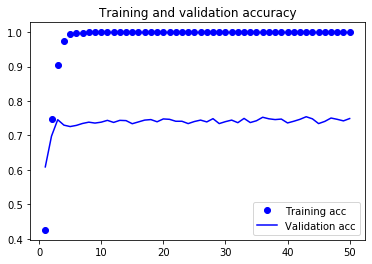

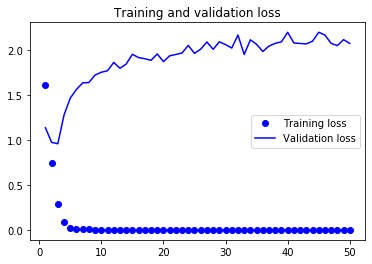

In [17]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 19s 2ms/step - loss: 1.6312 - categorical_accuracy: 0.4060 - val_loss: 1.1984 - val_categorical_accuracy: 0.5967
Epoch 2/20
10649/10649 [==============================] - 18s 2ms/step - loss: 0.7433 - categorical_accuracy: 0.7465 - val_loss: 0.9476 - val_categorical_accuracy: 0.6868
Epoch 3/20
10649/10649 [==============================] - 18s 2ms/step - loss: 0.2722 - categorical_accuracy: 0.9122 - val_loss: 1.1690 - val_categorical_accuracy: 0.6970
Epoch 4/20
10649/10649 [==============================] - 18s 2ms/step - loss: 0.0533 - categorical_accuracy: 0.9869 - val_loss: 1.2626 - val_categorical_accuracy: 0.7341
Epoch 5/20
10649/10649 [==============================] - 18s 2ms/step - loss: 0.0116 - categorical_accuracy: 0.9982 - val_loss: 1.5387 - val_categorical_accuracy: 0.7139
Epoch 6/20
10649/10649 [==============================] - 18s 2ms/step - loss: 0.0041 - categori

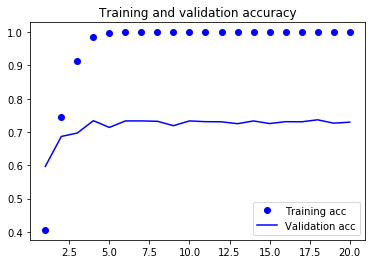

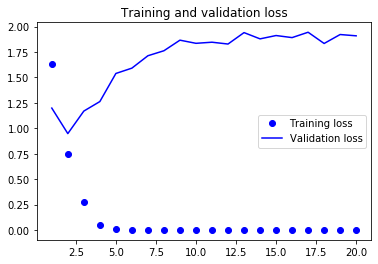

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()